In [1]:
!nvidia-smi

Fri Jun 18 21:15:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,185 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,415 kB]
Hit:1

In [23]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# **Seed**

In [4]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [21]:
%%capture
import gym
import random

env = gym.make('LunarLander-v2')

fix(env, seed)

In [6]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
box2d-py==2.3.8
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.5
cftime==1.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==9.1.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed

# **Model**

In [31]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        # self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(16, 1)


    def forward(self, state):
        hid = self.relu(self.fc1(state))
        # hid = self.relu(self.fc2(hid))
      
        return F.softmax(self.fc3(hid), dim=-1), self.fc4(hid)

class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.01)
         
    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, dis_rewards, values):
    # def learn(self, log_probs, rewards, dis_rewards, values, next_values):

        # calculating loss

        # Version 3.5
        mse_loss = nn.MSELoss()
        advantages = dis_rewards - values
        total_loss = (-log_probs * advantages).sum() + mse_loss(values, dis_rewards)
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        # # Version 4.0
        # mse_loss = nn.MSELoss()
        # advantages = rewards + next_values - values
        # total_loss = (-log_probs * advantages).sum() + mse_loss(values, dis_rewards)
        # self.optimizer.zero_grad()
        # total_loss.backward()
        # self.optimizer.step()


        
    def sample(self, state):
        action_prob, value = self.network(torch.FloatTensor(state))
        # action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob, value

In [32]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [33]:
agent.network.train()  # 確保 network 處在 training 模式
EPISODE_PER_BATCH = 10  # 每蒐集 EPISODE_PER_BATCH 個 episodes 更新一次 agent
NUM_BATCH = 800        # 總共更新 NUM_BATCH 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards, dis_rewards, values, next_values = [], [], [], [], [] # for training
    total_rewards, final_rewards = [], [] # for plotting

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob, value = agent.sample(state) 

            next_state, reward, done, _ = env.step(action)

            _, _, next_value = agent.sample(next_state)

            # rewards.append(reward)
            seq_rewards.append(reward)
            log_probs.append(log_prob)
            values.append(value)
            next_values.append(next_value)

            state = next_state
            total_reward += reward

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # calculating discounted rewards:
        temp = 0
        start = len(dis_rewards)
        for r in seq_rewards[::-1]:
            temp = r + 0.99 * temp
            dis_rewards.insert(start, temp)
        
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    print("Average total rewards: ",avg_total_reward, " | Average final rewards: ", avg_final_reward)
    # 更新網路

    # Version 3.5
    dis_rewards = (dis_rewards - np.mean(dis_rewards)) / (np.std(dis_rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(dis_rewards), torch.tensor(values))

    # # Version 4.0
    # rewards = (rewards - np.mean(dis_rewards)) / (np.std(dis_rewards) + 1e-9)  # 將 reward 正規標準化
    # dis_rewards = (dis_rewards - np.mean(dis_rewards)) / (np.std(dis_rewards) + 1e-9)  # 將 reward 正規標準化
    # agent.learn(torch.stack(log_probs), torch.from_numpy(rewards), torch.from_numpy(dis_rewards), torch.tensor(values), torch.tensor(next_values))


Average total rewards:  -262.91395148450556  | Average final rewards:  -100.0
Average total rewards:  -197.30038929532657  | Average final rewards:  -100.0
Average total rewards:  -206.67441887345413  | Average final rewards:  -100.0
Average total rewards:  -158.9528848831104  | Average final rewards:  -100.0
Average total rewards:  -165.59647483936368  | Average final rewards:  -100.0
Average total rewards:  -99.02826120313298  | Average final rewards:  -100.0
Average total rewards:  -141.66711907168175  | Average final rewards:  -100.0
Average total rewards:  -170.5317258624509  | Average final rewards:  -100.0
Average total rewards:  -196.99432643391907  | Average final rewards:  -100.0
Average total rewards:  -150.55336586314777  | Average final rewards:  -100.0
Average total rewards:  -143.24933673793447  | Average final rewards:  -100.0
Average total rewards:  -183.79173784457205  | Average final rewards:  -100.0
Average total rewards:  -143.0193977815267  | Average final rewards

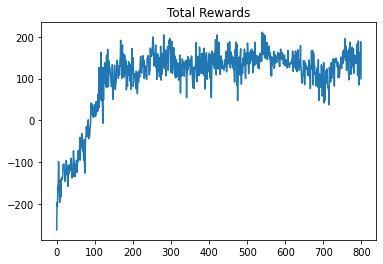

In [34]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

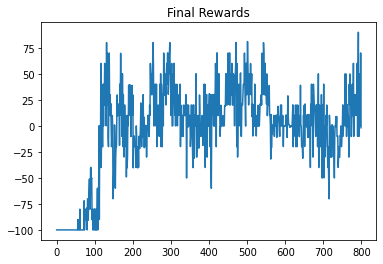

In [35]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

# **Testing**

In [36]:
fix(env, seed)
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  # img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ ,value= agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


202.3921195248186
length of actions is  545
250.4436098377839
length of actions is  259
133.68839530616168
length of actions is  1000
197.54947023899237
length of actions is  698
84.48874836378323
length of actions is  1000


In [37]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 173.71


# **Action** **Distribution**

In [38]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 1374, 2: 629, 0: 111, 3: 1388}


In [39]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [40]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>